# Import Dependencies and Load Data

In [3]:
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from category_encoders import TargetEncoder, LeaveOneOutEncoder

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 100)

ModuleNotFoundError: No module named 'statsmodels.formula.api'

In [ ]:
df = pd.read_csv('../datasets/car_price_prediction.csv')
df.shape

(19237, 18)

# Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,19237.00,45576535.89,936591.42,20746880.00,45698374.00,45772308.00,45802036.00,45816654.00
Price,19237.00,18555.93,190581.27,1.00,5331.00,13172.00,22075.00,26307500.00
Prod. year,19237.00,2010.91,5.67,1939.00,2009.00,2012.00,2015.00,2020.00
Cylinders,19237.00,4.58,1.20,1.00,4.00,4.00,4.00,16.00
Airbags,19237.00,6.58,4.32,0.00,4.00,6.00,12.00,16.00


In [ ]:
df.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(313)

In [ ]:
duplicates = df[df.duplicated]
duplicates

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
425,45815372,7840,-,MERCEDES-BENZ,E 200,1998,Sedan,No,CNG,2,180003 km,4.00,Manual,Rear,04-May,Left wheel,Black,4
1581,45815363,8781,-,TOYOTA,Ist,2002,Hatchback,No,Petrol,1.5,117000 km,4.00,Automatic,4x4,04-May,Right-hand drive,Red,4
1697,45732125,18503,-,TOYOTA,Prius,2010,Sedan,No,Petrol,1.8,162000 km,4.00,Automatic,Front,04-May,Left wheel,Grey,12
1972,45507765,20385,-,MERCEDES-BENZ,CLS 500,2005,Sedan,Yes,Petrol,5,230000 km,8.00,Tiptronic,Rear,04-May,Left wheel,Silver,10
2131,45815363,8781,-,TOYOTA,Ist,2002,Hatchback,No,Petrol,1.5,117000 km,4.00,Automatic,4x4,04-May,Right-hand drive,Red,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18974,45815465,2352,1273,LEXUS,IS 350,2015,Sedan,Yes,Petrol,3.5,80856 km,6.00,Automatic,4x4,04-May,Left wheel,Black,12
19137,45810466,15125,642,CHEVROLET,Orlando,2012,Jeep,Yes,Diesel,2,156834 km,4.00,Automatic,Front,04-May,Left wheel,Golden,4
19200,45725908,36065,640,MERCEDES-BENZ,CLA 250 AMG,2013,Sedan,Yes,Petrol,2.0 Turbo,68000 km,4.00,Tiptronic,Front,04-May,Left wheel,Red,12
19203,45761487,13485,645,TOYOTA,Prius,2011,Sedan,No,Hybrid,1.8,281600 km,6.00,Automatic,Front,04-May,Left wheel,Grey,8


In [ ]:
df = df.drop_duplicates()
df.shape

(18924, 18)

In [ ]:
df.nunique()

ID                  18924
Price                2315
Levy                  559
Manufacturer           65
Model                1590
Prod. year             54
Category               11
Leather interior        2
Fuel type               7
Engine volume         107
Mileage              7687
Cylinders              13
Gear box type           4
Drive wheels            3
Doors                   3
Wheel                   2
Color                  16
Airbags                17
dtype: int64

In [ ]:
df = df.drop('ID', axis=1)

In [ ]:
for col in df.columns:
    print(col, df[col].value_counts().head(20))

Price Price
15681    274
470      264
392      237
14113    236
10976    233
314      232
12544    221
7840     220
17249    213
18817    213
9408     198
627      190
10036    178
549      173
20385    173
706      166
10349    163
13172    155
23521    152
11604    149
Name: count, dtype: int64
Levy Levy
-       5709
765      482
891      453
639      403
640      398
781      294
1017     291
707      268
836      259
642      259
779      249
777      240
585      213
831      206
586      188
1172     186
761      182
1399     176
1091     168
730      167
Name: count, dtype: int64
Manufacturer Manufacturer
HYUNDAI          3729
TOYOTA           3606
MERCEDES-BENZ    2043
FORD             1088
CHEVROLET        1047
BMW              1036
HONDA             960
LEXUS             927
NISSAN            645
VOLKSWAGEN        571
SSANGYONG         439
KIA               417
OPEL              396
MITSUBISHI        288
SUBARU            274
AUDI              254
MAZDA             175
JEEP  

- In **Levy** feature have an oddly value `-` which is not a valid value. We can temporarily replace it with `NaN` and process later.
- **Leather interior** only have 2 unique values is `Yes` and `No`. We can replace it with `1` and `0`.
- Remove `km` in **Mileage** and convert it to `int`.
- Values in **Doors** 

In [ ]:
print(f"{df[df['Levy'] == '-'].shape[0]} of '-' values in 'Levy' column have been replace with Nan.")
df['Levy'] = df['Levy'].replace('-', np.nan)
df['Levy'] = df['Levy'].astype(float)

5709 of '-' values in 'Levy' column have been replace with Nan.


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,18924.00,18587.44,192135.63,1.00,5331.00,13172.00,22063.00,26307500.00
Levy,13215.00,906.30,463.30,87.00,640.00,781.00,1058.00,11714.00
Prod. year,18924.00,2010.91,5.67,1939.00,2009.00,2012.00,2015.00,2020.00
Cylinders,18924.00,4.58,1.20,1.00,4.00,4.00,4.00,16.00
Airbags,18924.00,6.57,4.32,0.00,4.00,6.00,12.00,16.00


## Statistical Insights

- **Price**:
    - The mean price is 18,587.44, but the standard deviation is extremely high (192,135.63), indicating a large spread in price values.
    - The minimum price is 1, which is likely an incorrect or missing value.
    - The maximum price (26,307,500) seems abnormally high, suggesting potential outliers or data entry errors.
    - The median price (13,172) is significantly lower than the mean, confirming a right-skewed distribution, likely due to a few extremely high prices.

    -> We can use Z-score or IQR to detect outliers in the this column.
    
- **Levy**:
    - 13215 out of 18924 rows have data, meaning ~30% of the data is missing.
    - The median (781) is close to the mean (906.94), which is a good sign that the data is not heavily skewed.
    - Potential outliers are present, as the maximum value (11,200) is much higher than Q3 (642).
    
    -> We can using some imputation method like `knn imputation` to fill missing values.

- **Prod. year**:
    - The minimum year is 1939, which is likely an incorrect value.
    - The median year is 2012, which is close to the mean year (2010).
    - The distribution of years is relatively uniform, with no clear outliers.
    
    -> We can go further to check the min value and consider remove or not.

    -> We can convert this column to `age` column to make it more meaningful.
    
    -> We can also convert year into categorical bins like `old (before 2000)`, `medium (2000-2010)`, `new (after 2010)` to improve model performance.

- **Cylinders**:
    - Most cars have 4 cylinders (Q1, Median, and Q3 are all 4).
    - There are some extreme values (Min = 1, Max = 16).
    - Cars with 16 cylinders are rare (luxury sports cars like Bugatti, high-end models).
    
    -> Convert into categories: `Low (1-3)`, `Standard (4-6)`, `High (8-16)`.
    
    -> Investigate 1-cylinder cars to check for data issues.

- **Airbags**:
    - The number of airbags ranges from 0 to 16, with a median of 4.
    - The distribution is right-skewed, with a few cars having a high number of airbags.
    
    -> Convert into categories: `Low (0-2)`, `Standard (4-6)`, `High (8-16)`.

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df['Levy'] = imputer.fit_transform(df['Levy'].values.reshape(-1, 1))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             18924 non-null  int64  
 1   Levy              18924 non-null  float64
 2   Manufacturer      18924 non-null  object 
 3   Model             18924 non-null  object 
 4   Prod. year        18924 non-null  int64  
 5   Category          18924 non-null  object 
 6   Leather interior  18924 non-null  object 
 7   Fuel type         18924 non-null  object 
 8   Engine volume     18924 non-null  object 
 9   Mileage           18924 non-null  object 
 10  Cylinders         18924 non-null  float64
 11  Gear box type     18924 non-null  object 
 12  Drive wheels      18924 non-null  object 
 13  Doors             18924 non-null  object 
 14  Wheel             18924 non-null  object 
 15  Color             18924 non-null  object 
 16  Airbags           18924 non-null  int64  
dty

We can try `Elbow method` to find the optimal number of clusters for KNN imputation for better performance.

In [ ]:
df.nunique()

Price               2315
Levy                 559
Manufacturer          65
Model               1590
Prod. year            54
Category              11
Leather interior       2
Fuel type              7
Engine volume        107
Mileage             7687
Cylinders             13
Gear box type          4
Drive wheels           3
Doors                  3
Wheel                  2
Color                 16
Airbags               17
dtype: int64

## Outliers Detection

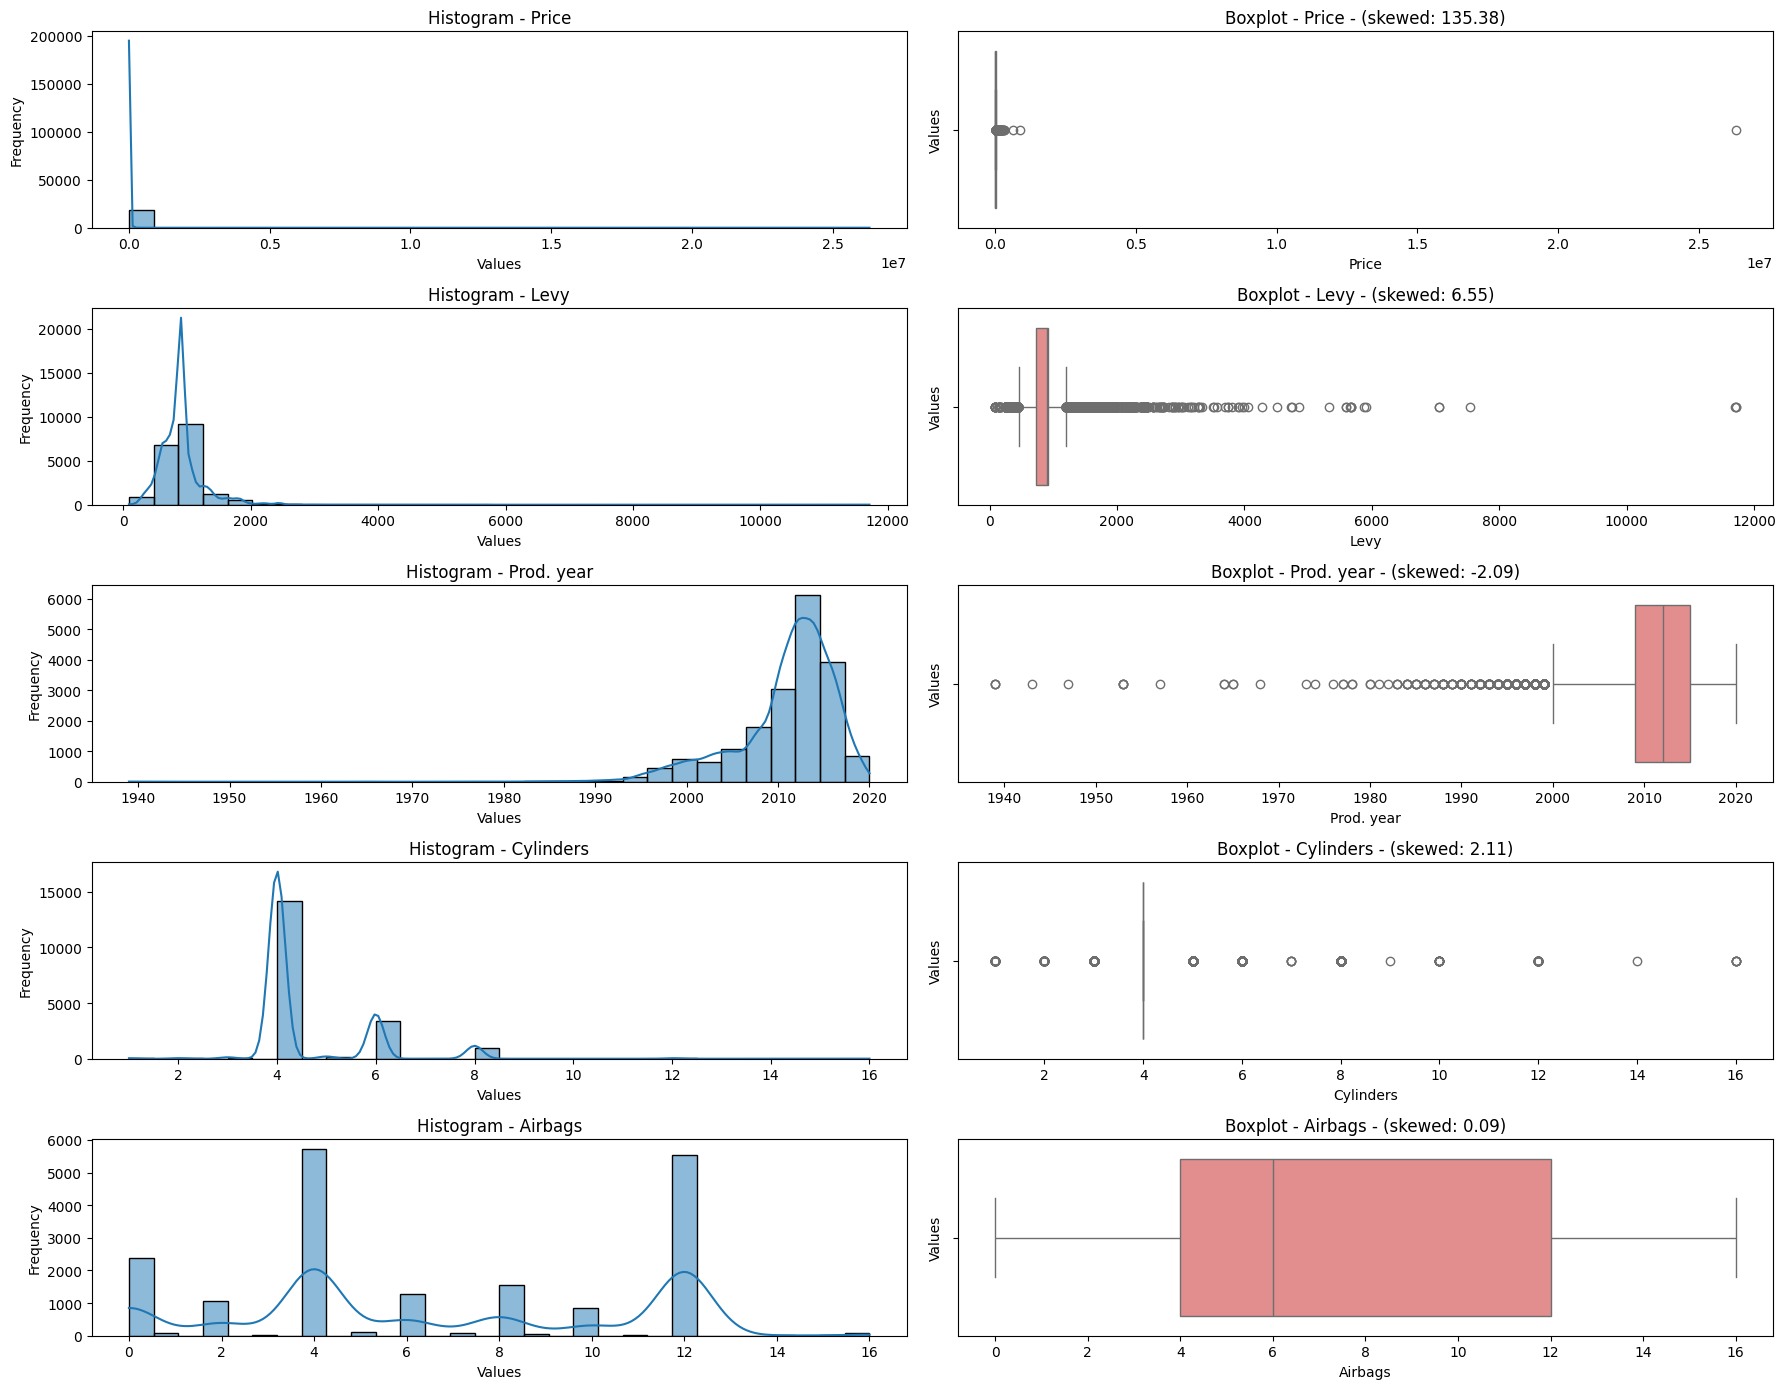

In [ ]:
numerical_features = df.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(5, 2, figsize=(18, 14))

for i, col in enumerate(numerical_features):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram - {col}")
    axes[i, 0].set_xlabel("Values")
    axes[i, 0].set_ylabel("Frequency")
    
    sns.boxplot(df[col], ax=axes[i, 1], color='lightcoral', orient='h')
    axes[i, 1].set_title(f"Boxplot - {col} - (skewed: {stats.skew(df[col]):.2f})")
    axes[i, 1].set_ylabel("Values")
    
plt.tight_layout()
plt.show()

In [ ]:
def IQR_limits(df, features):
    """
    Removes outliers using the IQR method for multiple numerical features.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features (list): List of numerical features to check for outliers.

    Returns:
    pd.DataFrame: The cleaned DataFrame without outliers.
    """
    df_clean = df.copy()
    
    for feature in features:
        Q1 = df_clean[feature].quantile(0.25)
        Q3 = df_clean[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = (df_clean[feature] < lower_bound) | (df_clean[feature] > upper_bound)
        print(f"Number of outliers in '{feature}' column: {outliers.sum()}")

        # Remove outliers
        df_clean = df_clean[~outliers]
    
    return df_clean

In [ ]:
df_test = df.copy()
df_test = IQR_limits(df_test, numerical_features)

Number of outliers in 'Price' column: 1055
Number of outliers in 'Levy' column: 2692
Number of outliers in 'Prod. year' column: 721
Number of outliers in 'Cylinders' column: 2818
Number of outliers in 'Airbags' column: 0


In [ ]:
df_test.shape   

(11638, 17)

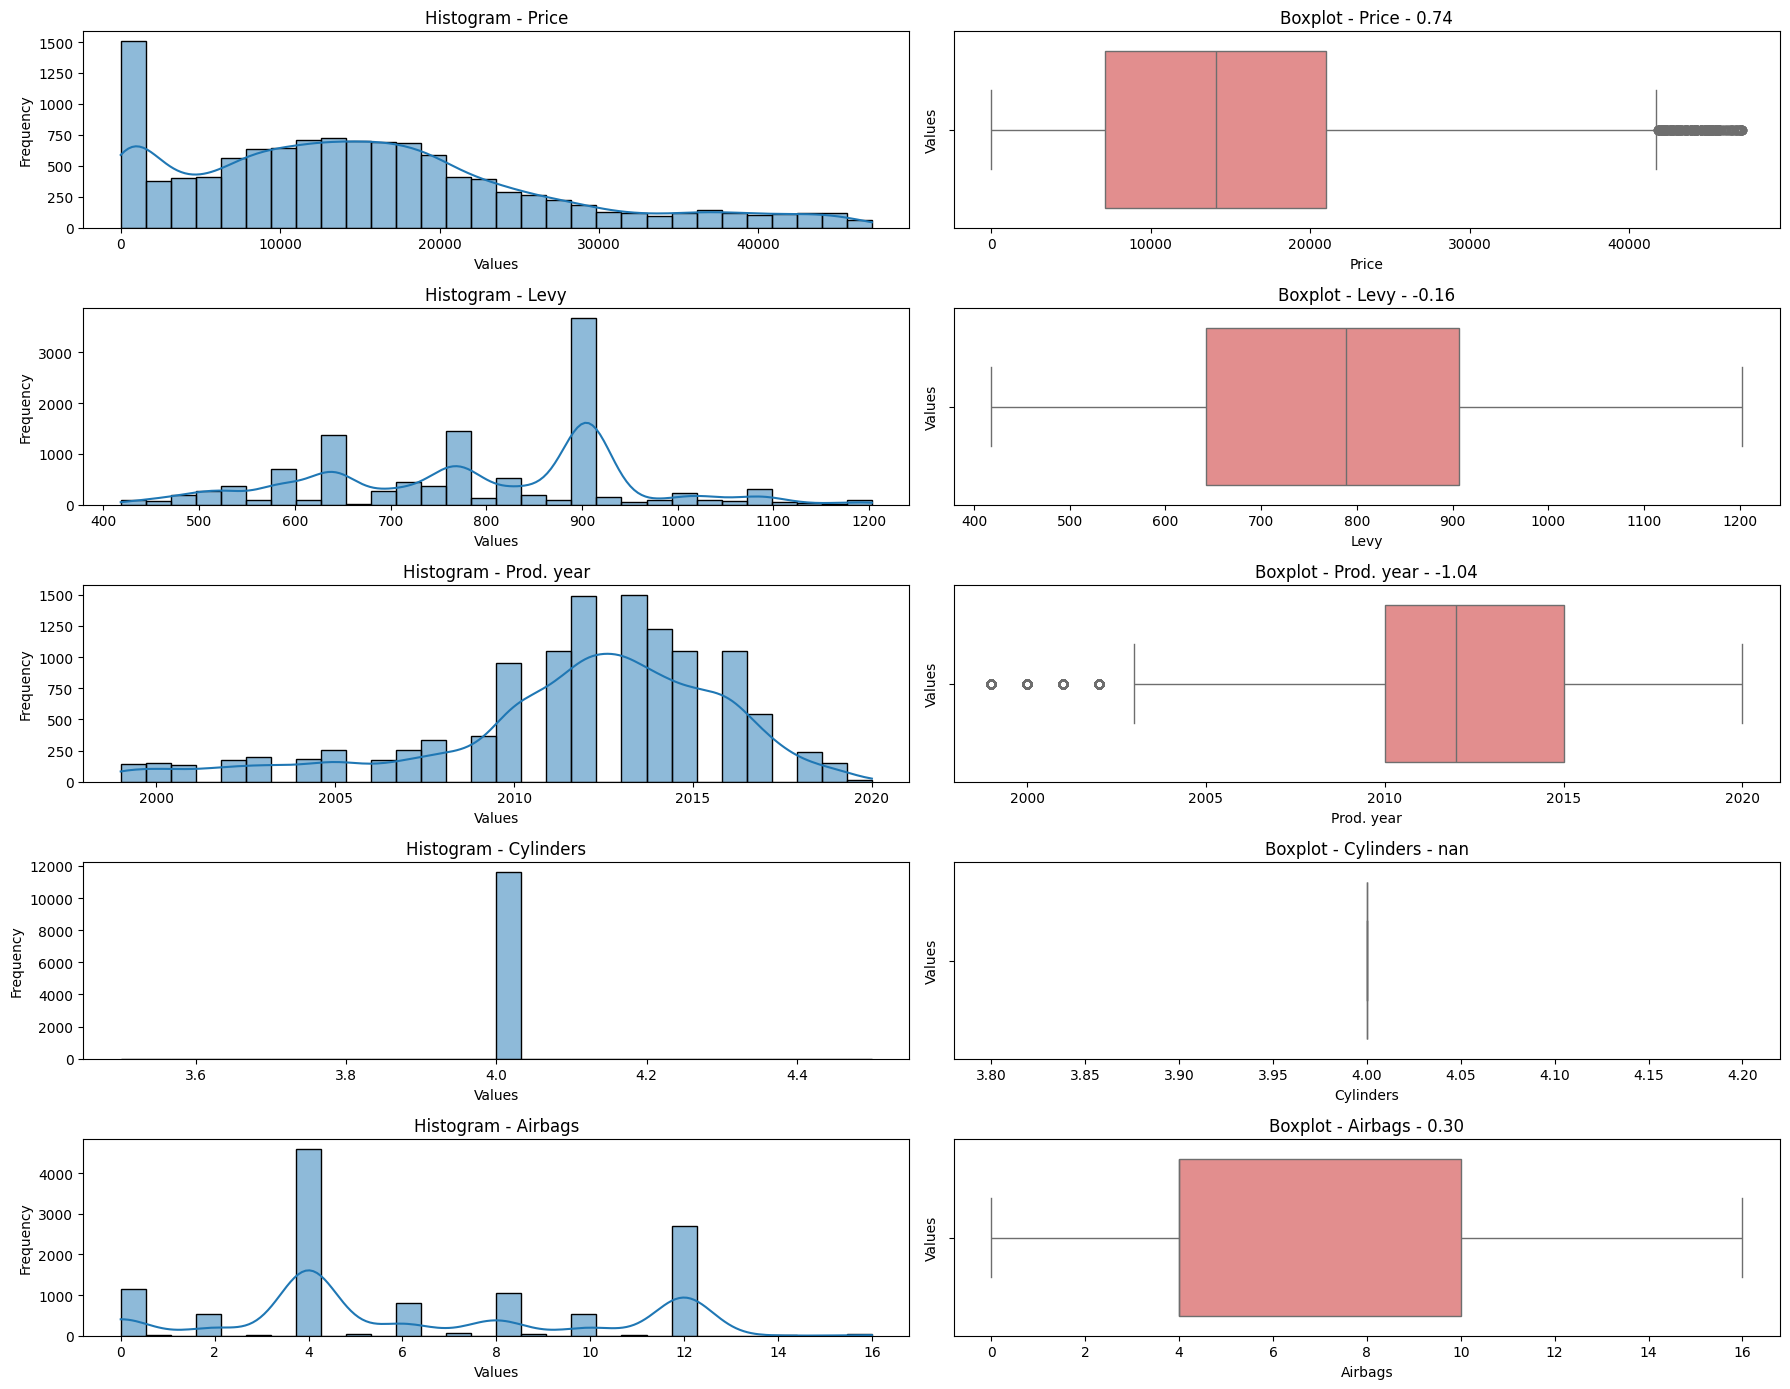

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(18, 14))

for i, col in enumerate(numerical_features):
    sns.histplot(df_test[col], kde=True, bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram - {col}")
    axes[i, 0].set_xlabel("Values")
    axes[i, 0].set_ylabel("Frequency")
    
    sns.boxplot(df_test[col], ax=axes[i, 1], color='lightcoral', orient='h')
    axes[i, 1].set_title(f"Boxplot - {col} - {stats.skew(df_test[col]):.2f}")
    axes[i, 1].set_ylabel("Values")
    
plt.tight_layout()
plt.show()

We can just remove outliers in `Price` column because it is the target column. 

In [ ]:
df = IQR_limits(df, ['Price'])
df.shape

Number of outliers in 'Price' column: 1055


(17869, 17)

## Categorical Data

### Manufacturer

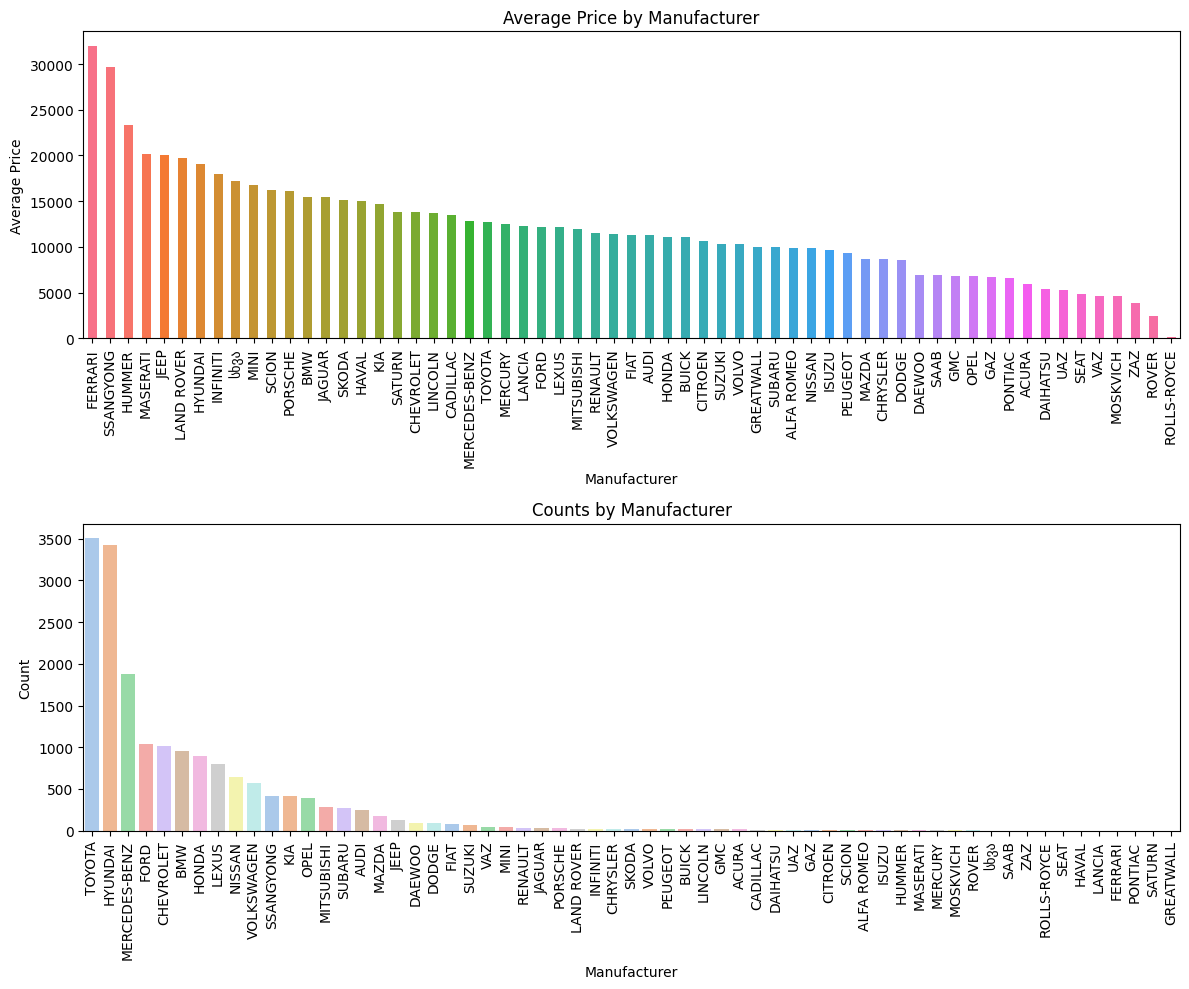

In [ ]:
average_price_by_manufacturer = df.groupby('Manufacturer')['Price'].mean().sort_values(ascending=False)
manufacturer_counts = df['Manufacturer'].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

colors_bar = sns.color_palette('husl', len(average_price_by_manufacturer))
average_price_by_manufacturer.plot(kind='bar', color=colors_bar, ax=axes[0])
axes[0].set_title('Average Price by Manufacturer')
axes[0].set_xlabel('Manufacturer')
axes[0].set_ylabel('Average Price')

colors_count = sns.color_palette('pastel')
sns.countplot(x='Manufacturer', data=df, order=df['Manufacturer'].value_counts().index, palette=colors_count, ax=axes[1])
axes[1].set_title('Counts by Manufacturer')
axes[1].set_xlabel('Manufacturer')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

plt.tight_layout()

plt.show()

In [ ]:

top_highest = average_price_by_manufacturer.head(3)
top_lowest = average_price_by_manufacturer.tail(3).sort_values(ascending=True)

top_counts = manufacturer_counts.head(3)
lowest_counts = manufacturer_counts.tail(3).sort_values(ascending=True)

print(f"Top 3 manufacturers with the highest average price: {top_highest}")
print("*"*80)
print(f"Top 3 manufacturers with the lowest average price: {top_lowest}")
print("_"*100)
print(f"Number of cars by top 3 manufacturers: {top_counts}")
print("*"*80)
print(f"Number of cars by lowest 3 manufacturers: {lowest_counts}")

Top 3 manufacturers with the highest average price: Manufacturer
FERRARI     31988.00
SSANGYONG   29697.71
HUMMER      23332.75
Name: Price, dtype: float64
********************************************************************************
Top 3 manufacturers with the lowest average price: Manufacturer
ROLLS-ROYCE    178.50
ROVER         2433.33
ZAZ           3822.50
Name: Price, dtype: float64
____________________________________________________________________________________________________
Number of cars by top 3 manufacturers: Manufacturer
TOYOTA           3502
HYUNDAI          3425
MERCEDES-BENZ    1874
Name: count, dtype: int64
********************************************************************************
Number of cars by lowest 3 manufacturers: Manufacturer
PONTIAC      1
SATURN       1
GREATWALL    1
Name: count, dtype: int64


Rolls-Royce is the manufacturer with the lowest avg price which is unrealistic. We can check for data issues.

In [ ]:
df[df["Manufacturer"] == "ROLLS-ROYCE"]

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
10265,157,906.30,ROLLS-ROYCE,Phantom,1939,Cabriolet,Yes,Petrol,5,129000 km,8.00,Automatic,Rear,04-May,Left wheel,Silver,0
15613,200,906.30,ROLLS-ROYCE,Phantom,1939,Limousine,Yes,Petrol,2.2,169000 km,4.00,Manual,Rear,04-May,Left wheel,White,0


The values of Rolls-Royce which is produced in 1939 is actually from $123,200 to $259,163. So this can be human error when inputting data. We can multiply the price by 1000 to fix this issue.

In [ ]:
# df_test = df.copy()
# df_test.loc[df_test['Manufacturer'] == "ROLLS-ROYCE", 'Price'] *= 1000
# df_test[df_test["Manufacturer"] == "ROLLS-ROYCE"]

In [ ]:
df['Model'].value_counts()

Model
Prius          1068
Sonata         1007
Elantra         907
Camry           905
E 350           526
               ... 
Combo 2001        1
Allante           1
YRV               1
C 240 W 203       1
Focus SEL         1
Name: count, Length: 1498, dtype: int64

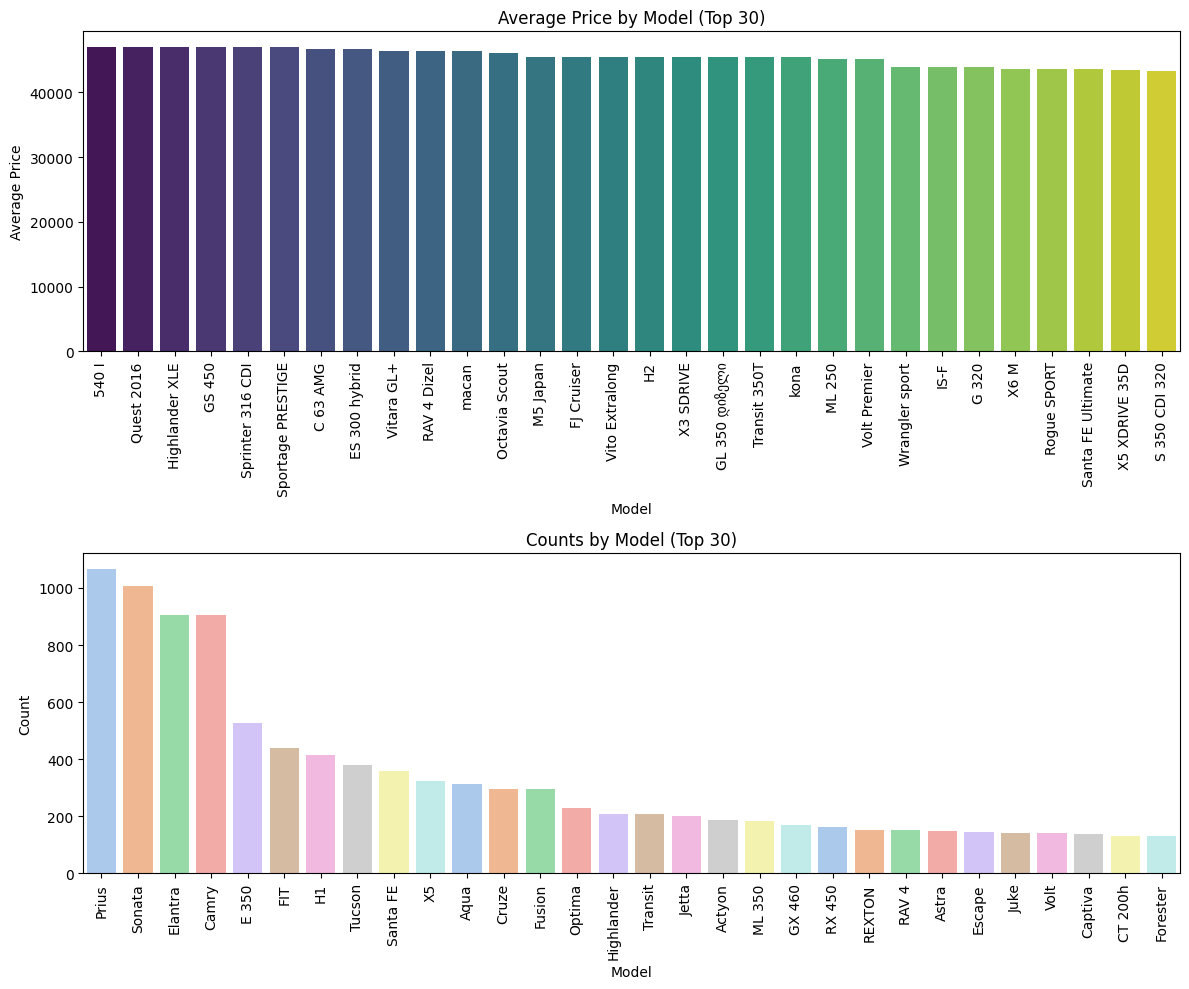

In [ ]:
average_price_by_model = df.groupby('Model')['Price'].mean().sort_values(ascending=False)
top_average_price_models = average_price_by_model.head(30).index

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

colors_price = sns.color_palette('viridis', len(top_average_price_models))
sns.barplot(x='Model', y='Price', data=df[df['Model'].isin(top_average_price_models)].sort_values('Price', ascending=False),
            palette=colors_price, ax=axes[0])
axes[0].set_title('Average Price by Model (Top 30)')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Average Price')
axes[0].tick_params(axis='x', rotation=90)  

top_count_models = df['Model'].value_counts().head(30).index
colors_count = sns.color_palette('pastel')
sns.countplot(x='Model', data=df[df['Model'].isin(top_count_models)].sort_values('Model'), order=top_count_models,
              palette=colors_count, ax=axes[1])
axes[1].set_title('Counts by Model (Top 30)')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)  

plt.tight_layout()

plt.show()

In [ ]:
df['Category'].value_counts()

Category
Sedan          8318
Jeep           4736
Hatchback      2781
Minivan         620
Coupe           477
Universal       339
Microbus        290
Goods wagon     227
Pickup           41
Cabriolet        29
Limousine        11
Name: count, dtype: int64

In [ ]:
df['Leather interior'].value_counts()

Leather interior
Yes    12737
No      5132
Name: count, dtype: int64

In [ ]:
df['Fuel type'].value_counts()

Fuel type
Petrol            9309
Diesel            3634
Hybrid            3495
LPG                878
CNG                469
Plug-in Hybrid      83
Hydrogen             1
Name: count, dtype: int64

In [ ]:
df['Engine volume'].value_counts()

Engine volume
2            3573
2.5          2167
1.8          1742
1.6          1428
1.5          1248
             ... 
5.4 Turbo       1
0.3 Turbo       1
5.2             1
5.8             1
1.1 Turbo       1
Name: count, Length: 103, dtype: int64

We can convert **Engine volume** and **Mileage** to `float` by remove `Turbo` and `km` string.

In [ ]:
# Create a new column 'Turbo' based on the presence of 'Turbo' in 'Engine volume'
df['Turbo'] = df['Engine volume'].apply(lambda x: 1 if 'Turbo' in str(x) else 0)

# Remove 'Turbo' string from 'Engine volume' and convert to numerical
df['Engine volume'] = df['Engine volume'].replace('Turbo', '', regex=True).astype(float)

df

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
0,13328,1399.00,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.50,186005 km,6.00,Automatic,4x4,04-May,Left wheel,Silver,12,0
1,16621,1018.00,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.00,192000 km,6.00,Tiptronic,4x4,04-May,Left wheel,Black,8,0
2,8467,906.30,HONDA,FIT,2006,Hatchback,No,Petrol,1.30,200000 km,4.00,Variator,Front,04-May,Right-hand drive,Black,2,0
3,3607,862.00,FORD,Escape,2011,Jeep,Yes,Hybrid,2.50,168966 km,4.00,Automatic,4x4,04-May,Left wheel,White,0,0
4,11726,446.00,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.30,91901 km,4.00,Automatic,Front,04-May,Left wheel,Silver,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,906.30,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.00,300000 km,4.00,Manual,Rear,02-Mar,Left wheel,Silver,5,1
19233,15681,831.00,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.40,161600 km,4.00,Tiptronic,Front,04-May,Left wheel,Red,8,0
19234,26108,836.00,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.00,116365 km,4.00,Automatic,Front,04-May,Left wheel,Grey,4,0
19235,5331,1288.00,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.00,51258 km,4.00,Automatic,Front,04-May,Left wheel,Black,4,0


In [ ]:
# Remove 'km' string from 'Mileage' and convert to numeric
df['Mileage'] = df['Mileage'].replace(' km', '', regex=True).astype(float)

In [ ]:
df['Cylinders'].value_counts()

Cylinders
4.00     13524
6.00      3140
8.00       804
5.00       167
3.00       107
2.00        42
1.00        35
12.00       29
10.00       10
16.00        5
7.00         4
9.00         1
14.00        1
Name: count, dtype: int64

In [ ]:
df['Drive wheels'].value_counts()

Drive wheels
Front    12155
4x4       3589
Rear      2125
Name: count, dtype: int64

In [ ]:
df['Doors'].value_counts()

Doors
04-May    17028
02-Mar      729
>5          112
Name: count, dtype: int64

Validate the values in **Doors** column.

In [ ]:
df['Doors'] = df['Doors'].replace({'04-May': '4-5', '02-Mar': '2-3'})
df["Doors"].astype('category')
df['Doors'].value_counts()

Doors
4-5    17028
2-3      729
>5       112
Name: count, dtype: int64

In [ ]:
df['Wheel'].value_counts()

Wheel
Left wheel          16420
Right-hand drive     1449
Name: count, dtype: int64

In [ ]:
df['Color'].value_counts()

Color
Black            4554
White            4143
Silver           3628
Grey             2167
Blue             1314
Red               606
Green             319
Orange            248
Carnelian red     173
Brown             168
Golden            139
Beige             130
Sky blue          121
Yellow             96
Purple             39
Pink               24
Name: count, dtype: int64

In [ ]:
df['Airbags'].value_counts()

Airbags
4     5245
12    5241
0     2268
8     1530
6     1258
2     1044
10     788
5      102
7       83
16      79
1       76
9       60
3       37
11      32
14      18
15       6
13       2
Name: count, dtype: int64

### Categorical Data vs Target

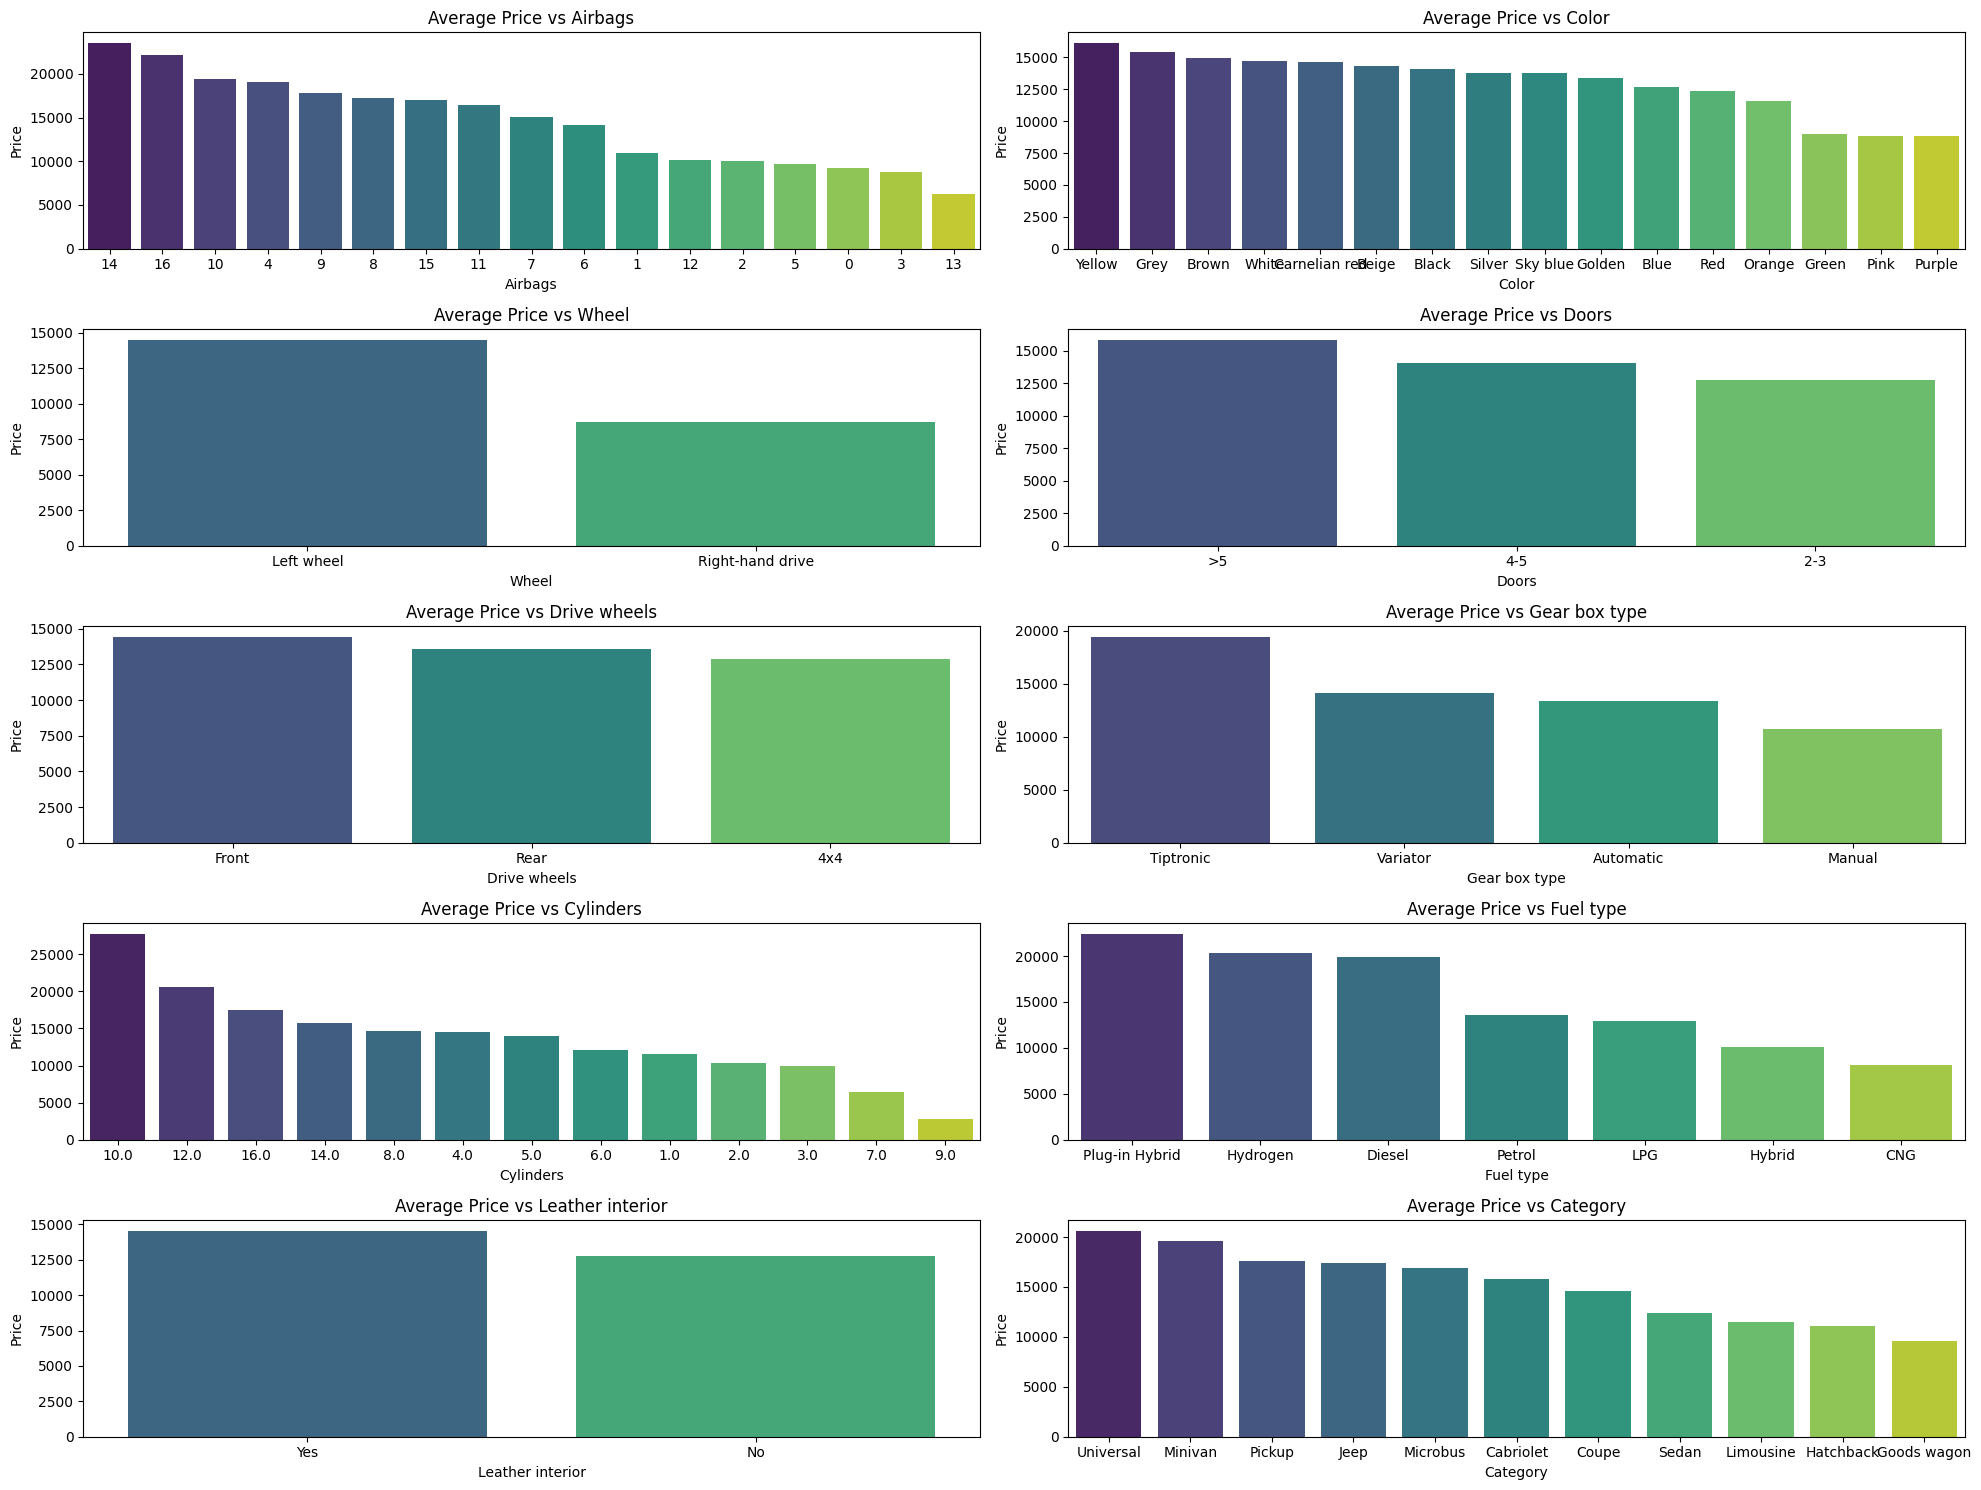

In [ ]:
columns_to_plot = ['Airbags', 'Color', 'Wheel', 'Doors', 'Drive wheels', 'Gear box type', 'Cylinders', 'Fuel type', 'Leather interior', 'Category']

# Create a 5x2 subplot grid
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15), tight_layout=True)

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate over the columns and create bar plots
for i, column in enumerate(columns_to_plot):
    # Sort the data by the average price in descending order
    sorted_data = df.groupby(column)['Price'].mean().sort_values(ascending=False).index
    
    sns.barplot(x=column, y='Price', data=df, order=sorted_data, ax=axes[i], ci=None, palette='viridis')
    axes[i].set_title(f'Average Price vs {column}')

# Adjust layout
plt.tight_layout()
plt.show()

# Feature Engineering

## Create new features

In [ ]:
df["Age"] = 2025 - df['Prod. year']
df = df.drop('Prod. year', axis=1)

We can create a group of **Prod year** or create a new feature `age` to make it more meaningful. In this case, I choose create a new feature `age` and drop `Prod. year`.

You can try to create bins for **Prod year** (Old, Medium, New).

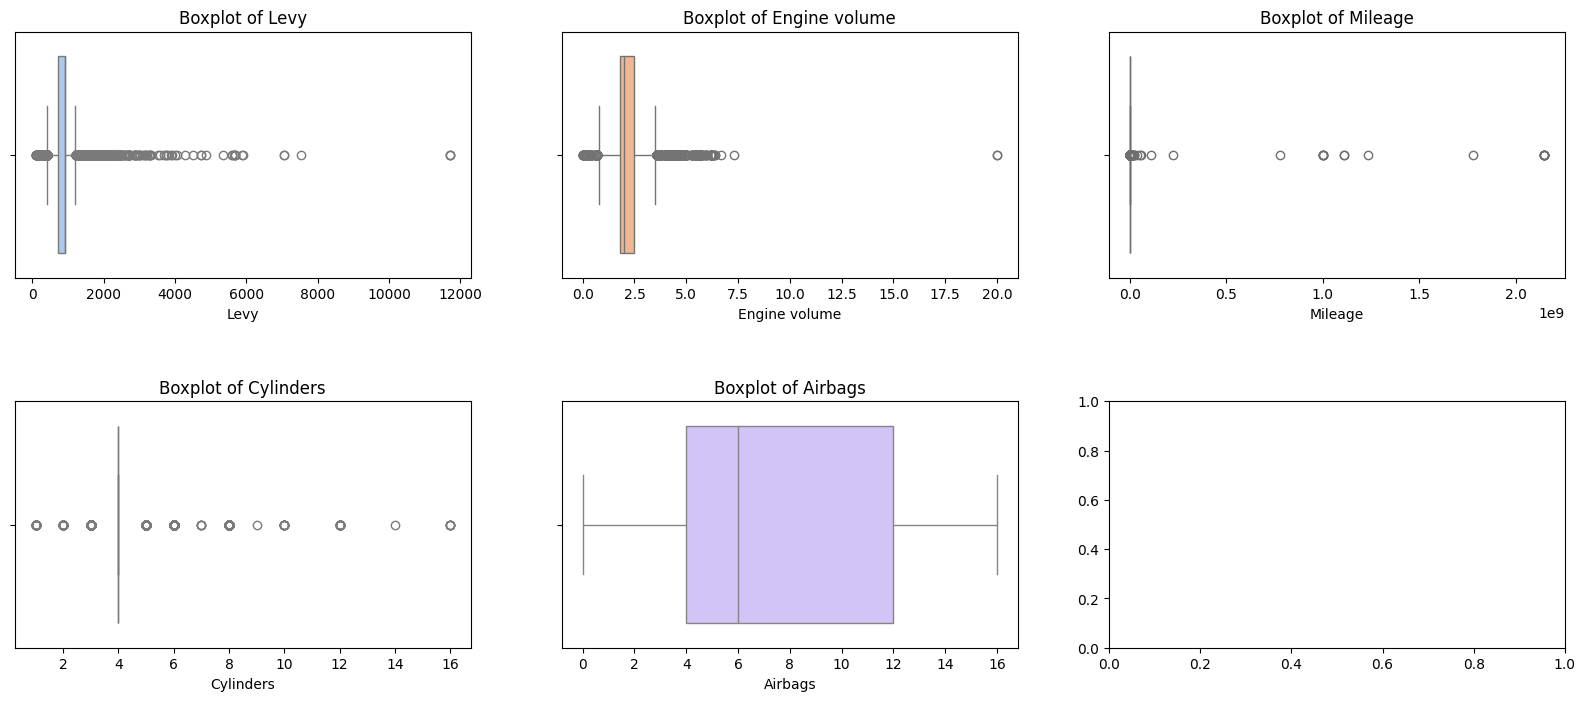

In [ ]:
columns_for_boxplots = ['Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

color_palette = sns.color_palette("pastel")

for i, column in enumerate(columns_for_boxplots):
    sns.boxplot(x=df[column], ax=axes[i], color=color_palette[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel(column)

plt.show()

The boxplots reveal important insights about our numerical features:

- **Levy**: Shows a right-skewed distribution with median around 700-800 and multiple outliers on the upper end. This suggests most vehicles have moderate levies, but some specialty vehicles incur significantly higher fees.

- **Engine volume**: Displays a concentrated distribution around 1.5-2.5L with clear outliers extending to 4.0L and beyond. The distribution reflects standard market segmentation with economy vehicles at the lower end and luxury/performance vehicles having larger engines.

- **Mileage**: Exhibits strong right skew with numerous high-value outliers. The median appears to be around 150,000 km, but there's considerable spread, indicating the dataset contains both newer vehicles and those with extensive usage history.

- **Cylinders**: Shows a discrete distribution with most vehicles having 4 cylinders (the median). The presence of 6 and 8 cylinder vehicles appears as outliers, representing higher-end or performance models.

- **Airbags**: Demonstrates a right-skewed discrete distribution. Most vehicles have 4-6 airbags, while modern luxury vehicles with comprehensive safety packages appear as outliers with 10-12 airbags.

These distributions will guide our preprocessing strategy, particularly for handling outliers and potentially creating categorical bins from continuous features.

In [ ]:
columns_for_boxplots = ['Levy', 'Engine volume', 'Mileage', 'Cylinders']

df = IQR_limits(df, columns_for_boxplots)

Number of outliers in 'Levy' column: 2692
Number of outliers in 'Engine volume' column: 335
Number of outliers in 'Mileage' column: 547
Number of outliers in 'Cylinders' column: 2597


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11698 entries, 2 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             11698 non-null  int64  
 1   Levy              11698 non-null  float64
 2   Manufacturer      11698 non-null  object 
 3   Model             11698 non-null  object 
 4   Category          11698 non-null  object 
 5   Leather interior  11698 non-null  object 
 6   Fuel type         11698 non-null  object 
 7   Engine volume     11698 non-null  float64
 8   Mileage           11698 non-null  float64
 9   Cylinders         11698 non-null  float64
 10  Gear box type     11698 non-null  object 
 11  Drive wheels      11698 non-null  object 
 12  Doors             11698 non-null  object 
 13  Wheel             11698 non-null  object 
 14  Color             11698 non-null  object 
 15  Airbags           11698 non-null  int64  
 16  Turbo             11698 non-null  int64  
 17

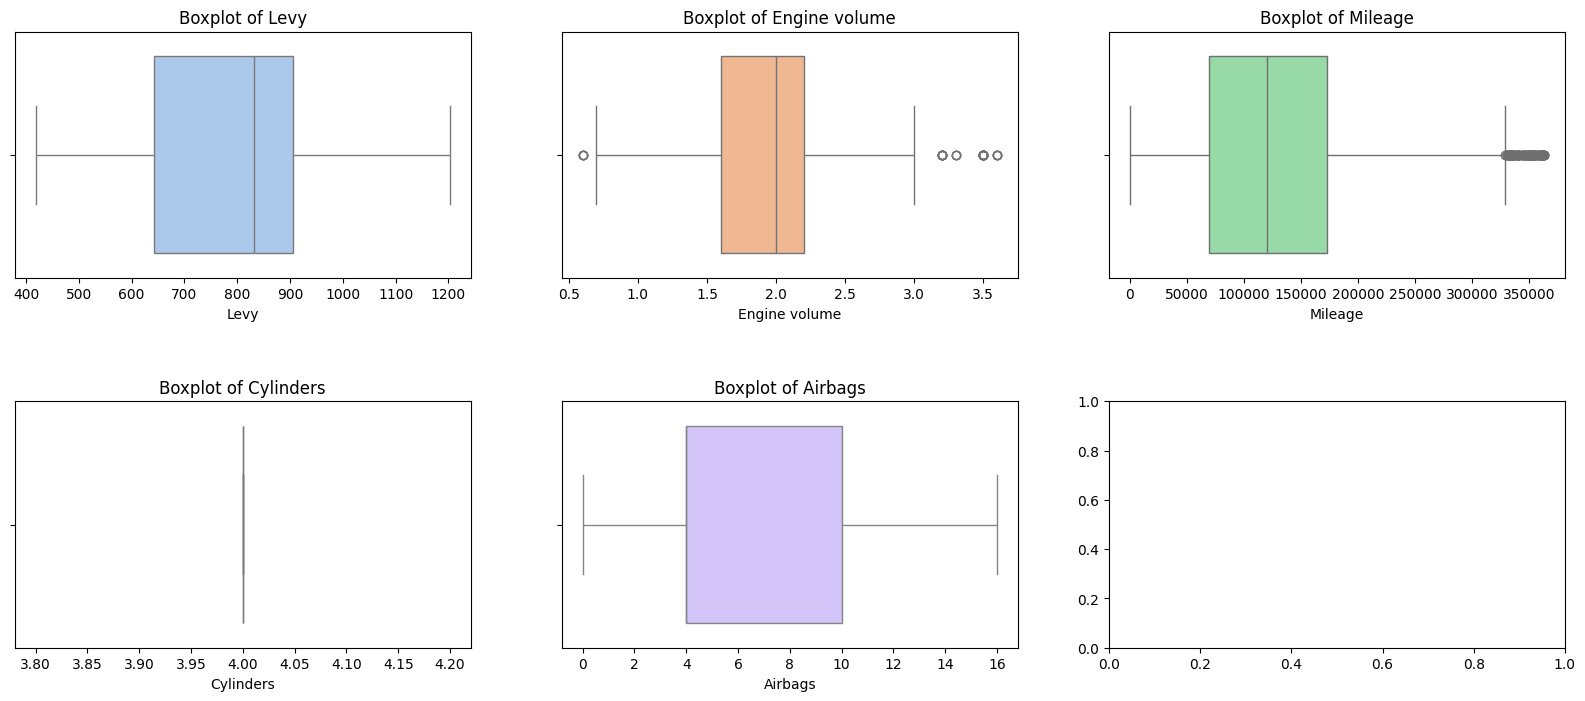

In [ ]:
columns_for_boxplots = ['Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

color_palette = sns.color_palette("pastel")

for i, column in enumerate(columns_for_boxplots):
    sns.boxplot(x=df[column], ax=axes[i], color=color_palette[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel(column)

plt.show()

The number of outliers is decreased after IQR method. It looks better now.

In the **Price** features, we have some values of 0 which is not realistic. Now we need to go deeper to check if there are any other values that are not realistic.

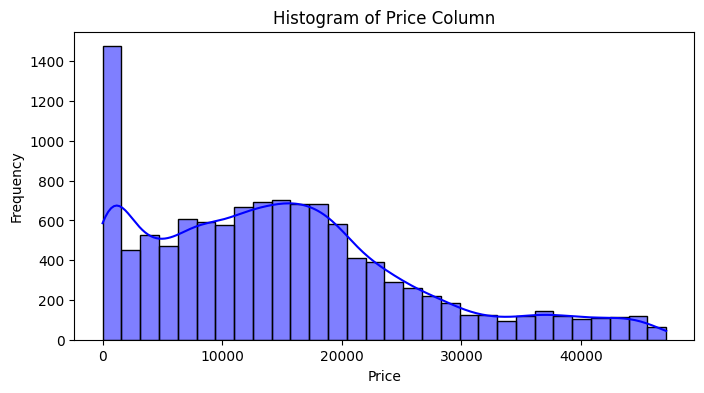

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Price'], bins=30, kde=True, color='blue', edgecolor='black')
plt.title('Histogram of Price Column')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Let's see how many cars have price less than 500.

In [ ]:
rows_with_low_price = df[df['Price'] < 500]

# Display the DataFrame with horizontal scrolling
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
display(rows_with_low_price)

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Age
27,30,906.30,TOYOTA,Prius,Sedan,No,Hybrid,1.50,169000.00,4.00,Automatic,Front,4-5,Left wheel,White,8,0,17
53,392,1017.00,MERCEDES-BENZ,E 300,Sedan,Yes,Petrol,2.00,1600.00,4.00,Automatic,Rear,4-5,Left wheel,Black,12,0,8
68,314,779.00,TOYOTA,Camry,Sedan,Yes,Hybrid,2.50,225510.00,4.00,Automatic,Front,4-5,Left wheel,White,12,0,12
79,220,1185.00,FORD,Escape,Jeep,Yes,Hybrid,2.50,193614.00,4.00,Automatic,Front,4-5,Left wheel,White,0,0,16
117,94,906.30,HONDA,FIT,Hatchback,No,Petrol,1.50,178000.00,4.00,Variator,Front,4-5,Right-hand drive,Silver,4,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19215,470,831.00,HYUNDAI,Elantra,Sedan,Yes,Petrol,1.60,25635.00,4.00,Automatic,Front,4-5,Left wheel,Black,12,0,8
19218,30,906.30,NISSAN,Note,Hatchback,No,Petrol,1.30,0.00,4.00,Automatic,Front,4-5,Right-hand drive,Green,9,0,19
19229,50,906.30,TOYOTA,Prius,Hatchback,No,Hybrid,1.50,150000.00,4.00,Automatic,Front,4-5,Left wheel,Silver,6,0,17
19230,470,645.00,TOYOTA,Prius,Hatchback,Yes,Hybrid,1.80,307325.00,4.00,Automatic,Front,4-5,Left wheel,Silver,12,0,14


We will remove these cars with prices below 500 because the prices are not realistic on these and it will create bias in the model if left in the data

In [ ]:
df = df[df['Price'] > 500]
df.shape

(10807, 18)

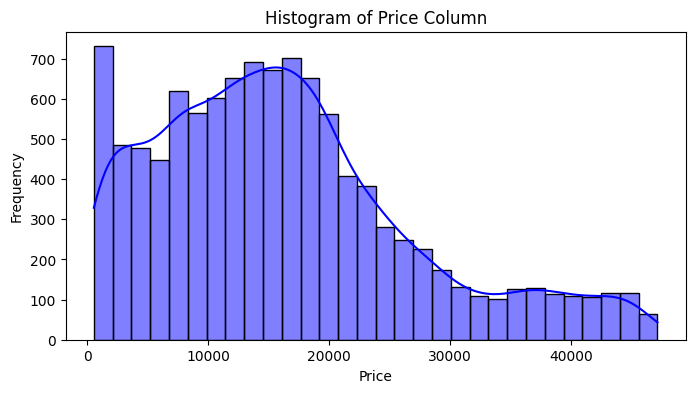

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Price'], bins=30, kde=True, color='blue', edgecolor='black')
plt.title('Histogram of Price Column')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

The distribution of **Price** looks better now but still right-skewed a little bit, so we can consider applying squared root or log transformation to make it more normally distributed.

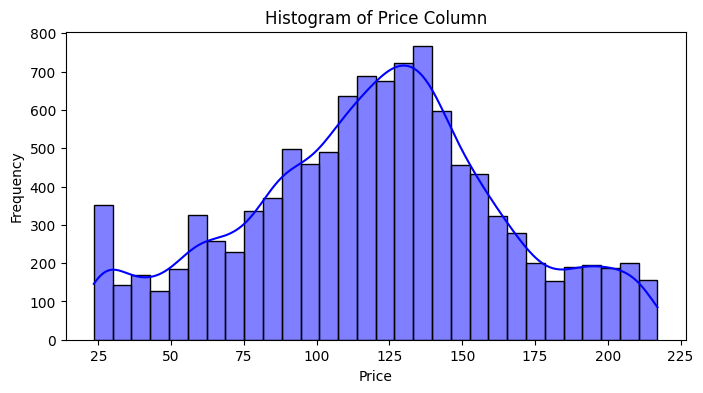

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(np.sqrt(df['Price']), bins=30, kde=True, color='blue', edgecolor='black')
plt.title('Histogram of Price Column')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Correlation Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10807 entries, 2 to 19234
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             10807 non-null  int64  
 1   Levy              10807 non-null  float64
 2   Manufacturer      10807 non-null  object 
 3   Model             10807 non-null  object 
 4   Category          10807 non-null  object 
 5   Leather interior  10807 non-null  object 
 6   Fuel type         10807 non-null  object 
 7   Engine volume     10807 non-null  float64
 8   Mileage           10807 non-null  float64
 9   Cylinders         10807 non-null  float64
 10  Gear box type     10807 non-null  object 
 11  Drive wheels      10807 non-null  object 
 12  Doors             10807 non-null  object 
 13  Wheel             10807 non-null  object 
 14  Color             10807 non-null  object 
 15  Airbags           10807 non-null  int64  
 16  Turbo             10807 non-null  int64  
 17

In [ ]:
numerical_features = df.select_dtypes(include=[np.number]).drop(columns=['Cylinders']).columns
numerical_features

Index(['Price', 'Levy', 'Engine volume', 'Mileage', 'Airbags', 'Turbo', 'Age'], dtype='object')

In [ ]:
df['Cylinders'].value_counts()

Cylinders
4.00    10807
Name: count, dtype: int64

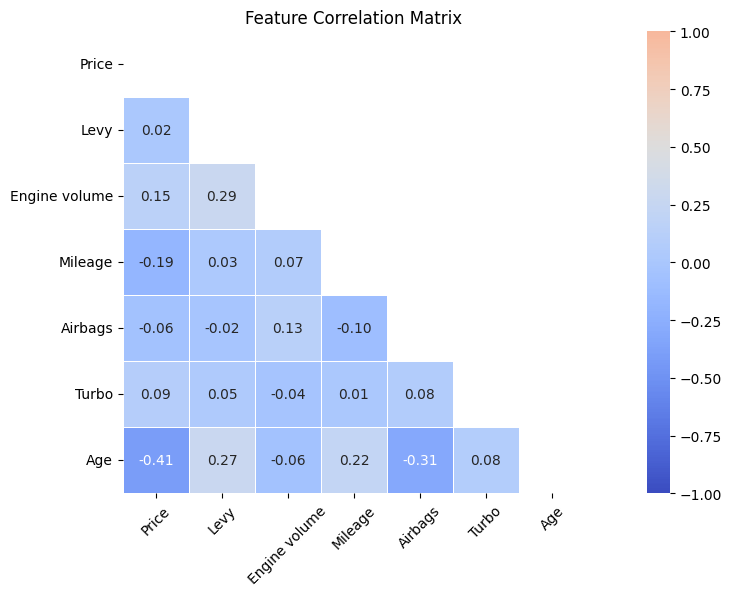

In [ ]:
plt.figure(figsize=(16, 6))
corr_mask = np.triu(np.ones_like(df[numerical_features].corr(), dtype=bool))

sns.heatmap(
    df[numerical_features].corr(),
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1, center=0.5,
    cmap='coolwarm',
    mask=corr_mask,
    square=True,
    linewidths=0.5
)
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

Multicollinearity not observed in the heatmap. Also we see there not too many features that have a strong correlation with the target

In [ ]:
target_corr = df[numerical_features].corr()['Price'].drop('Price')

top_positive = target_corr.sort_values(ascending=False).head(3)
top_negative = target_corr.sort_values(ascending=True).head(3)

print(f"Top 3 features positively correlated with 'Price':\n{top_positive}")
print("\n")
print(f"Top 3 features negatively correlated with 'Price':\n{top_negative}")


Top 3 features positively correlated with 'Price':
Engine volume   0.15
Turbo           0.09
Levy            0.02
Name: Price, dtype: float64


Top 3 features negatively correlated with 'Price':
Age       -0.41
Mileage   -0.19
Airbags   -0.06
Name: Price, dtype: float64


In [ ]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns
categorical_features

Index(['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type',
       'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color'],
      dtype='object')

In [ ]:
df[categorical_features].nunique()

Manufacturer         54
Model               951
Category             11
Leather interior      2
Fuel type             6
Gear box type         4
Drive wheels          3
Doors                 3
Wheel                 2
Color                16
dtype: int64

### OneHot Encoding

In [ ]:
models = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "LinearRegression": LinearRegression(),
    "XGBRegressor": XGBRegressor(random_state=42)
}

In [ ]:
scoring = {
    'r2': make_scorer(r2_score),
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error)
}

In [ ]:
df_onehot = df.copy(deep=True)
df_onehot = pd.get_dummies(df_onehot, columns=categorical_features, drop_first=True)
df_onehot

Price    Levy  Engine volume   Mileage  Cylinders  Airbags  Turbo  Age  \
2       8467  906.30           1.30 200000.00       4.00        2      0   19   
3       3607  862.00           2.50 168966.00       4.00        0      0   14   
4      11726  446.00           1.30  91901.00       4.00        4      0   11   
5      39493  891.00           2.00 160931.00       4.00        4      0    9   
6       1803  761.00           1.80 258909.00       4.00       12      0   15   
...      ...     ...            ...       ...        ...      ...    ...  ...   
19224  19130  906.30           2.40  35800.00       4.00       12      0   11   
19225   8781 1107.00           1.70 236000.00       4.00        4      1   18   
19232   8467  906.30           2.00 300000.00       4.00        5      1   26   
19233  15681  831.00           2.40 161600.00       4.00        8      0   14   
19234  26108  836.00           2.00 116365.00       4.00        4      0   15   

       Manufacturer_ALFA ROMEO  Manufacturer_AUDI  Manufacturer_BMW  \
2                        False              False             False   
3                        False              False             False   
4                        False              False             False   
5                        False              False             False   
6                        False              False             False   
...                        ...                ...               ...   
19224                    False              False             False   
19225                    False              False             False   
19232                    False              False             False   
19233                    False              False             False   
19234                    False              False             False   

       Manufacturer_BUICK  Manufacturer_CADILLAC  Manufacturer_CHEVROLET  \
2                   False                  False                   False   
3                   False                  False                   False   
4                   False                  False                   False   
5                   False                  False                   False   
6                   False                  False                   False   
...                   ...                    ...                     ...   
19224               False                  False                   False   
19225               False                  False                   False   
19232               False                  False                   False   
19233               False                  False                   False   
19234               False                  False                   False   

       Manufacturer_CHRYSLER  Manufacturer_CITROEN  Manufacturer_DAEWOO  \
2                      False                 False                False   
3                      False                 False                False   
4                      False                 False                False   
5                      False                 False                False   
6                      False                 False                False   
...                      ...                   ...                  ...   
19224                  False                 False                False   
19225                  False                 False                False   
19232                  False                 False                False   
19233                  False                 False                False   
19234                  False                 False                False   

       Manufacturer_DAIHATSU  Manufacturer_DODGE  Manufacturer_FIAT  \
2                      False               False              False   
3                      False               False              False   
4                      False               False              False   
5                      False               False              False   
6           

In [ ]:
for col in df_onehot.columns:
    if df_onehot[col].dtype == 'bool':
        df_onehot[col] = df_onehot[col].astype(int)

df_onehot.head()

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,Turbo,Age,Manufacturer_ALFA ROMEO,Manufacturer_AUDI,Manufacturer_BMW,Manufacturer_BUICK,Manufacturer_CADILLAC,Manufacturer_CHEVROLET,Manufacturer_CHRYSLER,Manufacturer_CITROEN,Manufacturer_DAEWOO,Manufacturer_DAIHATSU,Manufacturer_DODGE,Manufacturer_FIAT,Manufacturer_FORD,Manufacturer_GAZ,Manufacturer_GMC,Manufacturer_HAVAL,Manufacturer_HONDA,Manufacturer_HYUNDAI,Manufacturer_INFINITI,Manufacturer_JAGUAR,Manufacturer_JEEP,Manufacturer_KIA,Manufacturer_LANCIA,Manufacturer_LAND ROVER,Manufacturer_LEXUS,Manufacturer_LINCOLN,Manufacturer_MAZDA,Manufacturer_MERCEDES-BENZ,Manufacturer_MERCURY,Manufacturer_MINI,Manufacturer_MITSUBISHI,Manufacturer_MOSKVICH,Manufacturer_NISSAN,Manufacturer_OPEL,Manufacturer_PEUGEOT,Manufacturer_PORSCHE,Manufacturer_RENAULT,Manufacturer_ROVER,Manufacturer_SAAB,Manufacturer_SATURN,Manufacturer_SCION,Manufacturer_SEAT,Manufacturer_SKODA,Manufacturer_SSANGYONG,Manufacturer_SUBARU,Manufacturer_SUZUKI,Manufacturer_TOYOTA,Manufacturer_UAZ,Manufacturer_VAZ,Manufacturer_VOLKSWAGEN,Manufacturer_VOLVO,Manufacturer_ZAZ,Manufacturer_სხვა,Model_100 NX,Model_1000,Model_1111,Model_114,Model_118,"Model_118 2,0",Model_118 M-sport LCI,Model_120,Model_1300,Model_147,Model_1500,Model_159,Model_190,Model_20,Model_200,Model_206,Model_206 CC,Model_207,Model_21,Model_2101 01,Model_2103 03,Model_2105,Model_2106,Model_2107,Model_2107 07,Model_2109,Model_2111,Model_2121 (Niva),Model_216,Model_220,Model_230,Model_24 10,Model_250,Model_270,Model_3.18E+38,Model_3008,Model_307,Model_3110,Model_31105,Model_31514,Model_31514 UAZ,Model_316,Model_316 i,Model_318,Model_318 318,Model_318 m,Model_318 რესტაილინგი,Model_318 სასწრაფოდ,Model_320,Model_320 2.0,Model_320 DIESEL,Model_320 Diesel,Model_320 i,Model_323,Model_323 F,Model_328,Model_328 DIZEL,Model_328 i,Model_328 sulev,Model_400,Model_400X,Model_406,Model_407,Model_416,Model_428,Model_428 Sport Line,Model_428 i,Model_4Runner,Model_500,Model_500 46 ml,Model_500 Abarth,Model_500 Lounge,Model_500 SPORT,Model_500 Sport,Model_500 s,Model_500 sport,Model_500 sport panorama,Model_500 turbo,Model_500C,Model_500C Lounge,Model_500L,Model_500L LONG,Model_500X,Model_500X Lounge,Model_508,Model_520,Model_520 d xDrive Luxury,Model_525,Model_525 TDI,Model_528,Model_528 i,Model_530,Model_535 Twinturbo,Model_616,Model_626,Model_807,Model_940,Model_969 luaz,Model_A 140,Model_A 160,Model_A 170,Model_A 170 Avangard,Model_A 170 CDI,Model_A 190,Model_A 200,Model_A3,Model_A3 4X4,Model_A3 PREMIUM,Model_A4,Model_A4 B5,Model_A4 B6,Model_A4 B7,Model_A4 S line,Model_A4 S4,Model_A4 Sline,Model_A4 premium,Model_A4 premium plius,Model_A5,Model_A6,Model_ATS,Model_Acadia,Model_Accent,Model_Accent GS,Model_Accent SE,Model_Accord,Model_Accord CL9 type S,Model_Actyon,Model_Aerio SX,Model_Agila,Model_Airtrek,Model_Airtrek turbo,Model_Allroad,Model_Almera,Model_Almera dci,Model_Alphard,Model_Altezza,Model_Altima,Model_Aqua,Model_Aqua HIBRID,Model_Aqua L paketi,Model_Aqua S,Model_Aqua s,Model_Aqua სასწრაფოდ,Model_Astra,Model_Astra 1600,Model_Astra A.H,Model_Astra BERTONE,Model_Astra CNG,Model_Astra G,Model_Astra GE,Model_Astra GTC 1.9 turbo dies,Model_Astra H,Model_Astra astra,Model_Astra g,Model_Astra gi,Model_Astra td,Model_Atenza,Model_Auris,Model_Avalon,Model_Avalon LIMITED,Model_Avalon limited,Model_Avella,Model_Avenger,Model_Avensis,Model_Aveo,Model_Azera,Model_B 170,Model_B 170 B Class,Model_B 170 Edition One,Model_B 180,Model_B 200,Model_B 200 Turbo,Model_B 220,Model_B9 Tribeca,Model_BB,Model_BRZ,Model_Belta,Model_Bluebird,Model_Bora,Model_C 180,Model_C 180 2.0,Model_C 180 komp,Model_C 200,Model_C 200 2.0,Model_C 200 KOMPRESSOR,Model_C 200 Kompressor,Model_C 220,Model_C 230,Model_C 230 2.0 kompresor,Model_C 240,Model_C 250,Model_C 250 1.8,Model_C 250 1.8 ტურბო,Model_C 250 A.M.G,Model_C 250 AMG,"Model_C 250 AMG-PAKET-1,8",Model_C 250 luxury,Model_C 280,Model_C 300,Model_C-MAX,Model_C-MAX HYBRID,Model_C-MAX PREMIUM,Model_C-MAX SE,Model_C-MAX SEL,Model_C4,Model_C5,M

In [ ]:
X = df_onehot.drop(['Price', 'Cylinders'], axis=1)
y = df_onehot['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#### Cross Validate

In [ ]:
results = {'Model': [], 'R-squared (Test)': [], 'MAE (Test)': [], 'MSE (Test)': [], 'Score Time': [], 'R-squared (Train)': [], 'MAE (Train)': [], 'MSE (Train)': [], 'Train Time': []}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Training {name}...")
    
    cv_results = cross_validate(model, X_train_scaled, y_train, cv=kf, scoring=scoring, n_jobs=-1, return_train_score=True)
    print("_"*50)
    
    results['Model'].append(name)
    results['R-squared (Test)'].append(cv_results['test_r2'].mean())
    results['MAE (Test)'].append(cv_results['test_mae'].mean())
    results['MSE (Test)'].append(cv_results['test_mse'].mean())    
    results['Score Time'].append(cv_results['score_time'].mean())
    
    results['R-squared (Train)'].append(cv_results['train_r2'].mean())
    results['MAE (Train)'].append(cv_results['train_mae'].mean())
    results['MSE (Train)'].append(cv_results['train_mse'].mean())
    results['Train Time'].append(cv_results['fit_time'].mean())
    
print("Training completed.")    

Training RandomForestRegressor...
____________________________________________________________________________________________________
Training GradientBoostingRegressor...
____________________________________________________________________________________________________
Training LinearRegression...
____________________________________________________________________________________________________
Training XGBRegressor...
____________________________________________________________________________________________________
Training completed.


In [ ]:
results_df = pd.DataFrame(results)
results_df

,Model,R-squared (Test),MAE (Test),MSE (Test),Score Time,R-squared (Train),MAE (Train),MSE (Train),Train Time
0,RandomForestRegressor,0.82,2901.06,20773022.90,0.11,0.97,1094.78,3052855.00,68.64
1,GradientBoostingRegressor,0.70,4323.00,35087226.40,0.02,0.73,4171.39,31920035.93,92.62
2,LinearRegression,0.53,5481.89,54489742.75,0.01,0.63,4784.69,43522676.45,6.08
3,XGBRegressor,0.81,3294.98,22683128.20,0.05,0.89,2570.07,12457839.20,5.44


#### Fit in all train set

In [ ]:
fit_results = {'Model': [], 'R-squared (Test)': [], 'MAE (Test)': [], 'MSE (Test)': [], 'R-squared (Train)': [], 'MAE (Train)': [], 'MSE (Train)': []}

for name, model in models.items():
    print(f"Fitting {name}...")
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    r2_test = r2_score(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = mean_squared_error(y_test, y_pred)
    
    fit_results['Model'].append(name)
    fit_results['R-squared (Test)'].append(r2_test)
    fit_results['MAE (Test)'].append(mae_test)
    fit_results['MSE (Test)'].append(mse_test)
    
    y_train_pred = model.predict(X_train_scaled)
    fit_results['R-squared (Train)'].append(r2_score(y_train, y_train_pred))
    fit_results['MAE (Train)'].append(mean_absolute_error(y_train, y_train_pred))
    fit_results['MSE (Train)'].append(mean_squared_error(y_train, y_train_pred))

print("Fitting completed.")

Fitting RandomForestRegressor...
Fitting GradientBoostingRegressor...
Fitting LinearRegression...
Fitting XGBRegressor...
Fitting completed.


In [ ]:
fit_results_df = pd.DataFrame(fit_results)
fit_results_df

,Model,R-squared (Test),MAE (Test),MSE (Test),R-squared (Train),MAE (Train),MSE (Train)
0,RandomForestRegressor,0.82,2816.05,19961018.79,0.97,1083.73,3018102.43
1,GradientBoostingRegressor,0.70,4242.22,32750620.33,0.73,4147.17,31598563.26
2,LinearRegression,0.52,5434.96,51959665.43,0.63,4801.05,43725636.43
3,XGBRegressor,0.80,3237.92,21651370.00,0.89,2631.55,13069056.00


<Axes: xlabel='Prediction', ylabel='Density'>

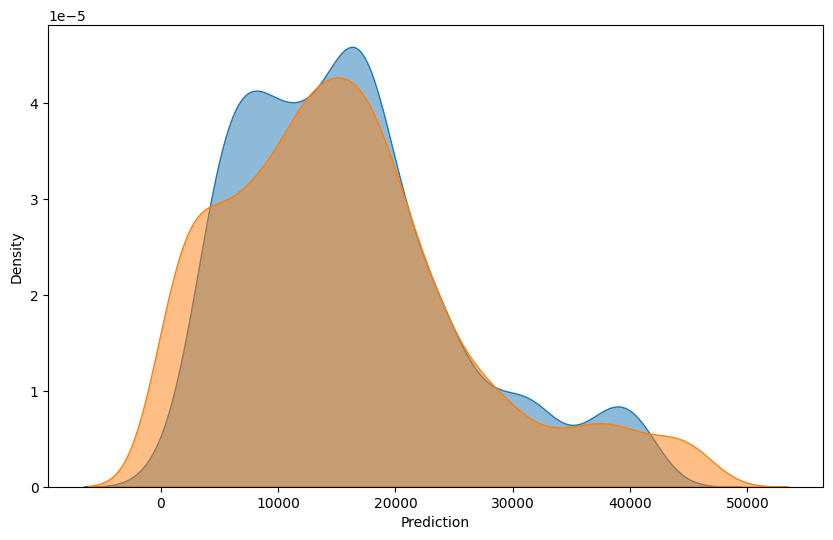

In [ ]:
plot_data = pd.DataFrame({'Prediction': y_pred, 'Actual': y_test})

plt.figure(figsize=(10, 6))
sns.kdeplot(data=plot_data, x='Prediction', fill=True, common_norm=False, palette='husl', alpha=.5)
sns.kdeplot(data=plot_data, x='Actual', fill=True, common_norm=False, palette='husl', alpha=.5)

#### Feature important

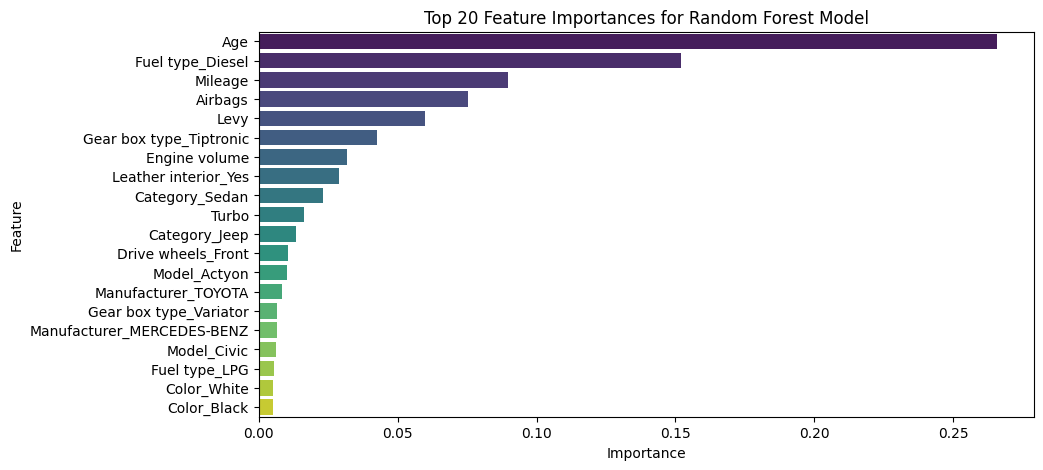

In [ ]:
feature_importances = models['RandomForestRegressor'].feature_importances_

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_20_features = feature_importance_df.head(20)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Feature Importances for Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Leave One Out Encoding (LOO)
In this method, I will apply Loo encoding to **Manufacturer**, **Model** and **Category**. Rest is encode with OneHot encode method

In [ ]:
df_loo = df.copy(deep=True)
columns_to_encode = ['Manufacturer', 'Model', 'Category']

encoder = LeaveOneOutEncoder(cols=columns_to_encode)

df_loo_encoded = encoder.fit_transform(df_loo[columns_to_encode], df_loo['Price'])

df_loo = pd.concat([df_loo, df_loo_encoded.add_suffix('_LOO')], axis=1)

df_loo.head()

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Age,Manufacturer_LOO,Model_LOO,Category_LOO
2,8467,906.30,HONDA,FIT,Hatchback,No,Petrol,1.30,200000.00,4.00,Variator,Front,4-5,Right-hand drive,Black,2,0,19,13127.21,13694.88,12825.65
3,3607,862.00,FORD,Escape,Jeep,Yes,Hybrid,2.50,168966.00,4.00,Automatic,4x4,4-5,Left wheel,White,0,0,14,14524.93,12630.41,22553.78
4,11726,446.00,HONDA,FIT,Hatchback,Yes,Petrol,1.30,91901.00,4.00,Automatic,Front,4-5,Left wheel,Silver,4,0,11,13122.02,13683.28,12823.97
5,39493,891.00,HYUNDAI,Santa FE,Jeep,Yes,Diesel,2.00,160931.00,4.00,Automatic,Front,4-5,Left wheel,White,4,0,9,20598.09,31222.12,22538.92
6,1803,761.00,TOYOTA,Prius,Hatchback,Yes,Hybrid,1.80,258909.00,4.00,Automatic,Front,4-5,Left wheel,White,12,0,15,15179.90,13899.42,12829.10


In [ ]:
df_loo.drop(columns=columns_to_encode, inplace=True)
cat_feat_loo = df_loo.select_dtypes(include=['object', 'category']).columns
cat_feat_loo

Index(['Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels',
       'Doors', 'Wheel', 'Color'],
      dtype='object')

In [ ]:
df_loo = pd.get_dummies(df_loo, columns=cat_feat_loo, drop_first=True)
df_loo.head()

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,Turbo,Age,Manufacturer_LOO,Model_LOO,Category_LOO,Leather interior_Yes,Fuel type_Diesel,Fuel type_Hybrid,Fuel type_LPG,Fuel type_Petrol,Fuel type_Plug-in Hybrid,Gear box type_Manual,Gear box type_Tiptronic,Gear box type_Variator,Drive wheels_Front,Drive wheels_Rear,Doors_4-5,Doors_>5,Wheel_Right-hand drive,Color_Black,Color_Blue,Color_Brown,Color_Carnelian red,Color_Golden,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
2,8467,906.30,1.30,200000.00,4.00,2,0,19,13127.21,13694.88,12825.65,False,False,False,False,True,False,False,False,True,True,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3607,862.00,2.50,168966.00,4.00,0,0,14,14524.93,12630.41,22553.78,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,11726,446.00,1.30,91901.00,4.00,4,0,11,13122.02,13683.28,12823.97,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
5,39493,891.00,2.00,160931.00,4.00,4,0,9,20598.09,31222.12,22538.92,True,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
6,1803,761.00,1.80,258909.00,4.00,12,0,15,15179.90,13899.42,12829.10,True,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [ ]:
X = df_loo.drop(['Price', 'Cylinders'], axis=1)
y = df_loo['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [115]:
for col in df_loo.columns:
    if df_loo[col].dtype == 'bool':
        df_loo[col] = df_loo[col].astype(int)

df_loo.head()

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,Turbo,Age,Manufacturer_LOO,Model_LOO,Category_LOO,Leather interior_Yes,Fuel type_Diesel,Fuel type_Hybrid,Fuel type_LPG,Fuel type_Petrol,Fuel type_Plug-in Hybrid,Gear box type_Manual,Gear box type_Tiptronic,Gear box type_Variator,Drive wheels_Front,Drive wheels_Rear,Doors_4-5,Doors_>5,Wheel_Right-hand drive,Color_Black,Color_Blue,Color_Brown,Color_Carnelian red,Color_Golden,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
2,8467,906.30,1.30,200000.00,4.00,2,0,19,13127.21,13694.88,12825.65,0,0,0,0,1,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3607,862.00,2.50,168966.00,4.00,0,0,14,14524.93,12630.41,22553.78,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,11726,446.00,1.30,91901.00,4.00,4,0,11,13122.02,13683.28,12823.97,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,39493,891.00,2.00,160931.00,4.00,4,0,9,20598.09,31222.12,22538.92,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,1803,761.00,1.80,258909.00,4.00,12,0,15,15179.90,13899.42,12829.10,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Modeling

In [1]:
results = {'Model': [], 'R-squared (Test)': [], 'MAE (Test)': [], 'MSE (Test)': [], 'Score Time': [], 'R-squared (Train)': [], 'MAE (Train)': [], 'MSE (Train)': [], 'Train Time': []}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Training {name}...")
    
    cv_results = cross_validate(model, X_train_scaled, y_train, cv=kf, scoring=scoring, n_jobs=-1, return_train_score=True)
    print("_"*50)
    
    results['Model'].append(name)
    results['R-squared (Test)'].append(cv_results['test_r2'].mean())
    results['MAE (Test)'].append(cv_results['test_mae'].mean())
    results['MSE (Test)'].append(cv_results['test_mse'].mean())    
    results['Score Time'].append(cv_results['score_time'].mean())
    
    results['R-squared (Train)'].append(cv_results['train_r2'].mean())
    results['MAE (Train)'].append(cv_results['train_mae'].mean())
    results['MSE (Train)'].append(cv_results['train_mse'].mean())
    results['Train Time'].append(cv_results['fit_time'].mean())
    
print("Training completed.")    

NameError: name 'KFold' is not defined